<a href="https://colab.research.google.com/github/JiayingTheWarriorForCS/Design.txt/blob/main/Interacting_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

This is a forked version from [here](https://colab.sandbox.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb). **Please make a copy before trying it out yourself!**

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gaofsfds
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gaofsfds
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=7a02aec4ccb5f7bf1e4e097f5bc68504d36a85d030df7e1cafd6e4114c20e989
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlr3ivid/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


<ipython-input-2-cc4b7f78b657>:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


Torch version: 2.5.0+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

# RN50 will be fastest, while ViT-L will be the most performant.
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 61.5MiB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [5]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

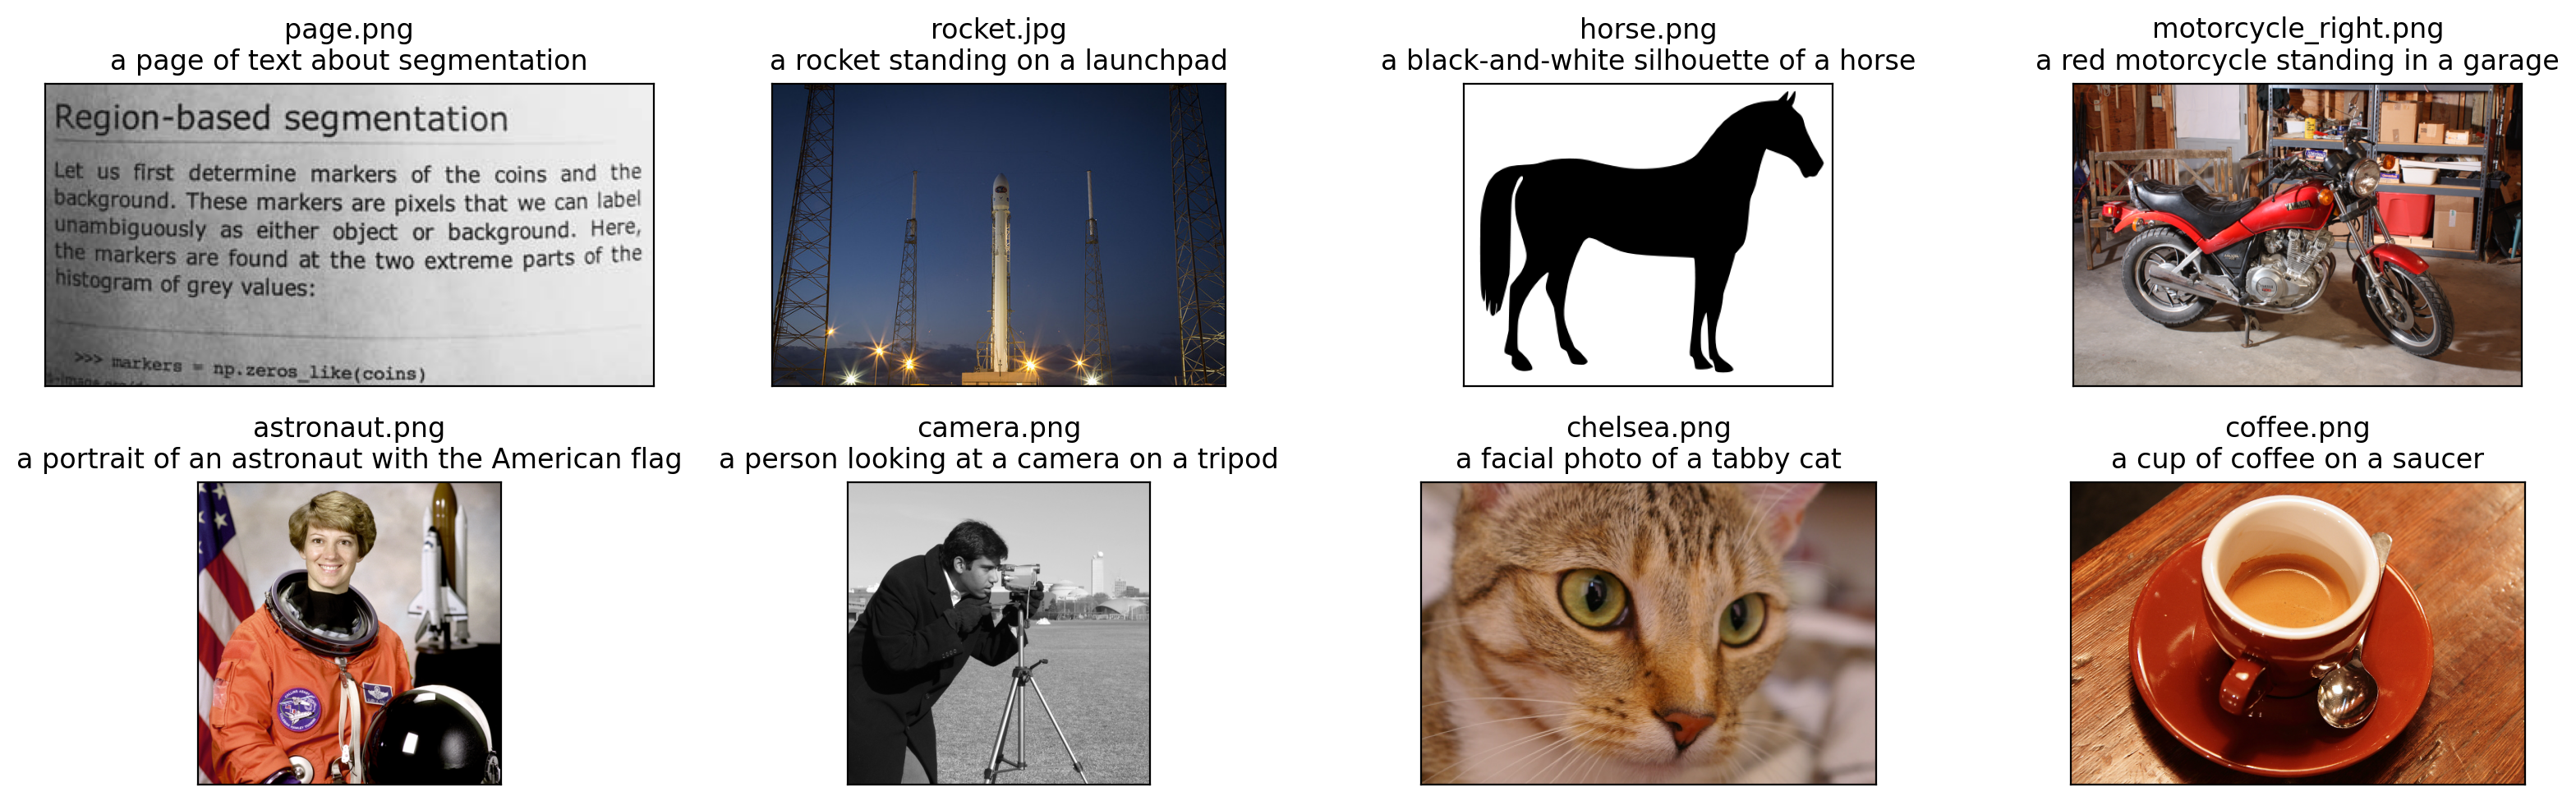

In [6]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))
skimage.data.download_all()
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [7]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [8]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [9]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

NameError: name 'image_input' is not defined

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10
import random
from torch.utils.data import DataLoader, Subset

cifar10_test = CIFAR10(root="~/.cache", train=False, transform=preprocess, download=True)
cifar10_train = CIFAR10(root="~/.cache", train=True, transform=preprocess, download=True)
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
cifar10 = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

Task 1

In [ ]:
random_indices = random.sample(range(len(cifar10)), 500)
selected_examples = torch.utils.data.Subset(cifar10, random_indices)
text_10_descriptions = [f"This is a photo of a {label}" for label in selected_examples.classes]
text_10_tokens = clip.tokenize(text_10_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_10_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
print(top_probs.shape)

In [ ]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(original_images):

    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar10.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

Task 2

In [ ]:
train_indices = random.sample(range(len(cifar10_train)), 1000)
train_subset = Subset(cifar10_train, train_indices)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
train_embeddings = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.cuda()
        image_features = model.encode_image(images).cpu().numpy()
        train_embeddings.append(image_features)
        train_labels.extend(labels.numpy())

train_embeddings = np.concatenate(train_embeddings)
train_labels = np.array(train_labels)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, train_labels)

In [ ]:
from sklearn.metrics import accuracy_score
test_indices = random.sample(range(len(cifar10_test)), 500)
test_subset = Subset(cifar10_test, test_indices)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
test_embeddings = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        image_features = model.encode_image(images).cpu().numpy()
        test_embeddings.append(image_features)
        test_labels.extend(labels.numpy())

test_embeddings = np.concatenate(test_embeddings)
test_labels = np.array(test_labels)
test_predictions = clf.predict(test_embeddings)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Task 2 2.0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
input_dim = 224
num_classes = 10


In [ ]:
import torch.nn as nn
import torch.optim as optim

class LinearClassifier(tf.keras.Model):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = tf.keras.layers.Dense(num_classes, input_shape=(input_dim,))

    def call(self, x):
        return self.linear(x)

model = LinearClassifier(input_dim=input_dim, num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss_metric = tf.keras.metrics.Mean()
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for epoch in range(15):
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    test_accuracy_metric.reset_states()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        with tf.GradientTape() as tape:
            logits = model(inputs, training=True)
            loss = loss_fn(labels, logits)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
for test_inputs, test_labels in test_loader:
        test_logits = model(test_inputs, training=False)
        test_accuracy_metric.update_state(test_labels, test_logits)
print(f" - Test Accuracy: {test_accuracy_metric.result() * 100:.2f}%")
        # train_loss_metric.update_state(loss)
        # train_accuracy_metric.update_state(labels, logits)
        # inputs, labels = data
        # optimizer.zero_grad()
        # outputs = net(inputs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()
        # running_loss += loss.item()

End of Task 2

Task 3

In [ ]:
list_of_objects = ["astronaut", "woman", "orange cloth", "American flag", "rocket", "smile", "blonde hair", "black hat"]

text_10_descriptions = [f"This is a photo of a {label}" for label in list_of_objects]
text_10_tokens = clip.tokenize(text_10_descriptions).cuda()

with torch.no_grad():
    text_features = model.encode_text(text_10_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)


In [ ]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(original_images):

    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar10.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

Task 4

In [ ]:
!pip install openai
import openai

client = openai.OpenAI(api_key=api_key)

list_of_objects = ["astronaut", "woman", "orange cloth", "American flag", "rocket", "smile", "blonde hair", "black hat"]

# In-context learning example to turn a list of objects into a caption.
# Note that the example was designed to be suboptimal on purpose.
completion = client.chat.completions.create(
    # Pricing: $0.50 / 1M tokens
    model="gpt-3.5-turbo-0125",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant. Use your imagination and"
                       "make the outputs as long and fancy as possible!!!"
        },
        {
            "role": "user",
            "content": "Your task is to convert a list of English words into a"
                       "nice looking sentence.",
        },
        {
            "role": "user",
            "content": "First example, input: astronaut,"
                       "output: An astronaut is standing in space.",
        },
        {
            "role": "user",
            "content": "Second example, input: astronaut, woman"
                       "output: A woman is wearing an astronaut suit.",
        },
        {
            "role": "user",
            "content": "Third example, input: astronaut, woman, orange cloth"
                       "output: The astronaut, who is a woman, is wearing an orange spacesuit.",
        },
        {
            "role": "user",
            "content": "Fourth example, input: astronaut, woman, orange cloth, American flag"
                       "output: A woman astronaut in an orange suit stands beside the American flag.",
        },
        {
            "role": "user",
            "content": "Fifth example, input: astronaut, woman, orange cloth, American flag, rocket"
                       "output: A woman astronaut in an orange spacesuit stands near a rocket, with the American flag waving beside her.",
        },
        {
            "role": "user",
            "content": "Sixth example, input: astronaut, woman, orange cloth, American flag, rocket, smile"
                       "output: A smiling woman astronaut in an orange suit stands beside a rocket, with the American flag in the background.",
        },
        {
            "role": "user",
            "content": "Seventh example, input: astronaut, woman, orange cloth, American flag, rocket, smile, blonde hair"
                       "output: A smiling woman astronaut with blonde hair stands in front of a rocket, wearing an orange suit and the American flag behind her.",
        },
        {
            "role": "user",
            "content": "Eighth example, input: astronaut, woman, orange cloth, American flag, rocket, smile, blonde hair, black hat"
                       "output: A smiling woman astronaut with blonde hair and a black hat stands beside a rocket, with the American flag in the background.",
        },
        {
            "role": "user",
            "content": "Query, input: astronaut, woman, orange cloth, American flag, rocket, smile, blonde hair, black hat"
                       "output:",
        },
    ]
)

print(completion.choices[0].message.content)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 500
    for image, label in selected_examples:
        image = image.unsqueeze(0).cuda()
        image_features = model.encode_image(image).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_probs = (500.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)
        # print(label)
        if top_labels.item() == label:
            correct += 1
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")
# text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()